In [20]:
import pandas as pd
import numpy as np
import re
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import math

## Read the data (這邊改成你要的APP，可以多個，但效果可能會變差)

In [146]:
file_names = ['shopee.csv', 'momo.csv', 'PChome.csv']
li = []
for path in file_names:
    df = pd.read_csv(path, index_col=None, header=0)
    li.append(df)

data_set = pd.concat(li, axis=0, ignore_index=True)
data_set.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOGv1sL5Itgbzg1iBMFj6BLoh1ZuFk_75MwNof4...,范彼得,https://play-lh.googleusercontent.com/a-/AOh14...,一般人看見1顆星都可能以為是惡意評價！但我是罪證確鑿的指控蝦皮！ 我向蝦皮授權賣家「喵狗XX...,1,13,2.81.07,2021-12-24 16:33:44,NaN,NaN
1,gp:AOqpTOEpZii_UQpE2RrYz4fcyLeKFwTMoxySgGhFc9r...,寶妮,https://play-lh.googleusercontent.com/a/AATXAJ...,"爛，氣死！海外賣家寄來包裹，app上顯示送達門市（14號）,19號去領只有一包有領到，還向店...",1,4,2.81.07,2021-12-24 18:03:01,NaN,NaN
2,gp:AOqpTOGuM1Xko8FfrnPcaDcnSxt6drzn-gJ17E8b5lI...,168.888 qin,https://play-lh.googleusercontent.com/a-/AOh14...,超贊的購物網站，公正合理誠信，不過還是有些不足要說來：為什麼把退貨退款有時侯匯入(街頭支付)...,5,3,2.81.07,2021-12-24 09:09:12,NaN,NaN
3,gp:AOqpTOFmreT5H90IAlbqB_bxW_W_DeJxHrPyFV3WRBL...,許孟慈,https://play-lh.googleusercontent.com/a-/AOh14...,自從膝關節退化無法出門逛街後，我就開始學習網路購物，已經有三年時間，也在很多的購物平台購物，...,5,0,2.81.07,2021-12-24 08:56:41,NaN,NaN
4,gp:AOqpTOGkd4kAUhZ7fNFD-ZUlcVAp8wvcyhGLnhDtQ8o...,浩克,https://play-lh.googleusercontent.com/a-/AOh14...,賣家稱：瑕疵難免。 買家取消交易，賣家口出惡言。 買家回應賣家：即使出貨，買家拒收，經截圖檢...,1,2,2.81.07,2021-12-24 22:19:58,NaN,NaN


In [147]:
print("Reviews Count :", data_set.shape[0])

Reviews Count : 69792


## Functions

#### Preprocessor function
consider 2 ~ 6 gram

In [104]:
def preprocess(sent, stopwords):
    sent = re.sub(r'[^\w]', '', sent)
    sent = re.sub(r'[A-Za-z0-9]', '', sent)
    return_list = [[], [], [], [], []]
    for n_gram in range(2, 7):
        for i in range(len(sent) - n_gram + 1):
            w = sent[i:i+n_gram]
            if w not in stopwords:
                return_list[n_gram-2].append(w)
    return return_list

In [105]:
stopwords = []
with open("stopwords.txt", 'r', encoding = 'utf8') as file:
    for data in file.readlines():
        data = data.strip()
        stopwords.append(data)

#### CF, TF and DF function

In [82]:
def CF_TF_DF_creator(n_gram_df, score_range = [1, 5]):
    CF_dict = [{}, {}, {}, {}, {}] # to remove rare words
    DF_dict = [{}, {}, {}, {}, {}]
    for score in range(score_range[0]-1, score_range[1]): # each score
        for doc in n_gram_df[score].keys(): # each reviewer
            doc_set = set()
            for n in range(2, 7): # each gram
                for w in n_gram_df[score][doc][n-2]:
                    if w not in CF_dict[n-2].keys(): # first occurance in collections
                        CF_dict[n-2][w] = 1
                        DF_dict[n-2][w] = 1
                        doc_set.add(w)
                    elif w not in doc_set: # first occurance in documents
                        CF_dict[n-2][w] += 1
                        DF_dict[n-2][w] += 1
                        doc_set.add(w)
                    else:
                        CF_dict[n-2][w] += 1
    print("CF and DF complete")
    
    # Remove the rare words ( CF < 1 % number of documents)
    for n in range(2, 7):
        temp = CF_dict[n-2].copy()
        min_CF = 0
        for score in range(score_range[0]-1, score_range[1]):
            min_CF += len(n_gram_df[score].keys())
        min_CF *= 0.01
        for w in temp.keys():
            if temp[w] < min_CF:
                del CF_dict[n-2][w]
                del DF_dict[n-2][w]
    print("Remove the rare words")
    
    # Remove combined words (use DF)
    for n in range(2, 7-1):
        temp = DF_dict[n-2].copy()
        for n_gram in temp.keys():
            for m_gram in DF_dict[n-1].keys(): # m = n+1
                if n_gram in m_gram and temp[n_gram] == DF_dict[n-1][m_gram]:
                    del CF_dict[n-2][n_gram]
                    del DF_dict[n-2][n_gram]
                    break
        print (n, end='\r')
    print("Remove combined words")
    
    TF_table = {}
    for score in range(score_range[0]-1, score_range[1]): # each score
        for doc in n_gram_df[score].keys(): # each reviewer
            TF_dict = {}
            for n in range(2, 7): # each gram
                for w in n_gram_df[score][doc][n-2]:
                    if w not in CF_dict[n-2].keys(): # has been removed
                        continue
                    elif w not in TF_dict: # first occurance in documents
                        TF_dict[w] = 1
                    else:
                        TF_dict[w] += 1
            TF_table[doc] = TF_dict
    print("TF complete")
    
    uni_tokens = []
    for n in range(2, 7): # each gram
        uni_tokens.extend(CF_dict[n-2].keys())
    
    return {'uni_tokens': uni_tokens, 'CF': CF_dict, 'DF': DF_dict, 'TF': TF_table}

## Tokenization

In [148]:
n_gram_df = [{}, {}, {}, {}, {}]
for index, val in data_set.iterrows():
    if type(val["content"]) != str:
        continue
    n_gram_df[val['score']-1][index] = preprocess(val['content'], stopwords)
    print (str(round(100 * (index + 1) / data_set.shape[0], 2)) + "%", end='\r')

## 使用CF_TF_DF_creator
CF_TF_DF_creator(n_gram_df, [min_score, max_score])，max_score有包含<br>
CF_TF_DF_creator吐出一個dict，包含unique_tokens, CF, DF, TF，以下稱CF_TF_DF <br>
CF_TF_DF['uni_tokens']是個list，包含所有unique的tokens <br>
CF_TF_DF['CF']是個list，CF_TF_DF['CF'][n-2]是n-gram的CF dict <br>
CF_TF_DF['DF']是個list，CF_TF_DF['DF'][n-2]是n-gram的DF dict <br>
CF_TF_DF['TF']是個dict，CF_TF_DF['TF'][doc_id]是doc_id這個review的TF dict <br>

In [149]:
CF_TF_DF = CF_TF_DF_creator(n_gram_df, [1, 2])

CF and DF complete
Remove the rare words
Remove combined words
TF complete


In [150]:
CF_TF_DF['CF'][2] # 4-gram 的 CF

{'取消訂單': 241,
 '貨到付款': 266,
 '一直顯示': 263,
 '還是一樣': 176,
 '實名認證': 372,
 '重新下載': 168,
 '無法使用': 261,
 '街口支付': 207,
 '無法登入': 205,
 '一直無法': 179,
 '很卡很卡': 250}

## CF 總排行

In [151]:
cf_rank = []
for n in range(2, 7):
    for key in CF_TF_DF['CF'][n-2].keys():
        cf_rank.append((key, CF_TF_DF['CF'][n-2][key]))
cf_rank = sorted(cf_rank, key=lambda x: x[1], reverse=True)
cf_rank[:20]

[('一直', 3485),
 ('更新', 3401),
 ('商品', 3377),
 ('蝦皮', 3274),
 ('無法', 2982),
 ('東西', 2788),
 ('賣家', 2686),
 ('客服', 2464),
 ('問題', 2462),
 ('使用', 2094),
 ('購物', 1926),
 ('真的', 1720),
 ('系統', 1379),
 ('手機', 1378),
 ('顯示', 1329),
 ('訂單', 1291),
 ('一個', 1279),
 ('根本', 1256),
 ('現在', 1238),
 ('不到', 1134)]

## DF 總排行

In [152]:
df_rank = []
for n in range(2, 7):
    for key in CF_TF_DF['DF'][n-2].keys():
        df_rank.append((key, CF_TF_DF['DF'][n-2][key]))
df_rank = sorted(df_rank, key=lambda x: x[1], reverse=True)
df_rank[:20]

[('一直', 2952),
 ('更新', 2602),
 ('無法', 2495),
 ('商品', 2443),
 ('東西', 2285),
 ('蝦皮', 2263),
 ('問題', 1867),
 ('客服', 1725),
 ('使用', 1651),
 ('賣家', 1622),
 ('購物', 1531),
 ('真的', 1424),
 ('顯示', 1141),
 ('根本', 1130),
 ('現在', 1116),
 ('系統', 1080),
 ('手機', 1067),
 ('一個', 1052),
 ('不到', 1035),
 ('都不', 1015)]

## Clustering

In [153]:
M = len(CF_TF_DF['uni_tokens'])
N = len(CF_TF_DF['TF'])

In [154]:
print('# of tokens :', M)
print('# of reviews :', N)

# of tokens : 538
# of reviews : 16700


In [155]:
doc_list = list(CF_TF_DF['TF'].keys())

In [156]:
TF_table = np.zeros((N, M))
for i in range(N):
    doc_id = doc_list[i]
    for j in range(M):
        token = CF_TF_DF['uni_tokens'][j]
        if token not in CF_TF_DF['TF'][doc_id].keys():
            continue
        else:
            TF_table[i][j] = CF_TF_DF['TF'][doc_id][token]

In [157]:
TF_table

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## K-means

find the best k

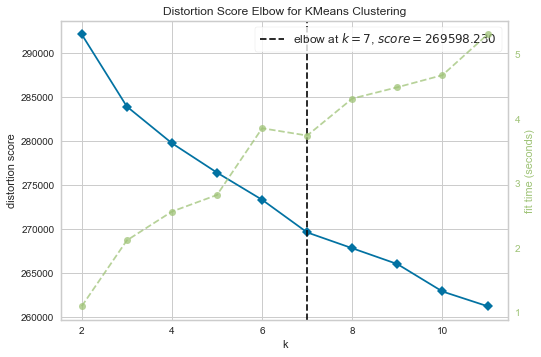

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [158]:
visualizer = KElbowVisualizer(KMeans(random_state=100), k=(2,12)).fit(TF_table)
visualizer.show()

In [159]:
best_k = visualizer.elbow_value_
print("Best k:", best_k)

Best k: 7


In [160]:
kmeans = KMeans(n_clusters=best_k, random_state=100).fit(TF_table)
clusters = kmeans.labels_

## Cluster Labeling

In [161]:
N_dict = {}
for w in range(M):
    token = CF_TF_DF['uni_tokens'][w]
    N_row = []
    for c in range(best_k):
        temp = [0, 0]
        for d in range(N):
            if clusters[d] != c:
                continue
            doc_id = doc_list[d]
            if token in CF_TF_DF['TF'][doc_id].keys():
                temp[1] += 1 # t = 1
            else:
                temp[0] += 1 # t = 0
        N_row.append(temp)
    N_dict[w] = N_row

In [162]:
temp, Nc = np.unique(clusters, return_counts=True)

In [163]:
LR_table = []
for c in range(best_k):
    LR_list = []
    for w in range(M):
        n_11 = N_dict[w][c][1]
        n_10 = Nc[c] - n_11
        n_01 = sum(x[1] for x in N_dict[w]) - n_11
        n_00 = N - n_11 - n_10 - n_01
        p_t = (n_11 + n_01) / N
        p_1 = n_11 / (n_11 + n_10)
        p_2 = n_01 / (n_01 + n_00)
        # optimize the LR computation
        LR = 0
        if p_1 != 0 and p_2 != 0 and p_1 != 1 and p_2 != 1:
            LR = -2 * (n_11 * math.log(p_t / p_1) + n_10 * math.log((1-p_t) / (1-p_1)) + n_01 * math.log(p_t / p_2) + n_00 * math.log((1-p_t) / (1-p_2)))
        LR_list.append((CF_TF_DF['uni_tokens'][w], LR))
    LR_list = sorted(LR_list, key=lambda x: x[1], reverse=True)
    LR_table.append((Nc[c], LR_list[:10]))

In [164]:
LR_table

[(11981,
  [('客服', 1176.5416693576396),
   ('問題', 1170.114638212777),
   ('名認證', 770.4403250812827),
   ('實名認', 747.7878269966848),
   ('名認', 735.7603832000887),
   ('實名', 425.0846722071682),
   ('的問', 416.52573111979945),
   ('賣家', 411.34037813097757),
   ('的問題', 410.71731321302735),
   ('法更', 398.2450598929654)]),
 (1,
  [('顆星', 0),
   ('以為', 0),
   ('評價', 0),
   ('我是', 0),
   ('蝦皮', 0),
   ('賣家', 0),
   ('買了', 0),
   ('電話', 0),
   ('這是', 0),
   ('大陸', 0)]),
 (1325,
  [('客服', 2924.3330300659577),
   ('問題', 2143.6321983823123),
   ('的問', 611.7699667737646),
   ('的問題', 605.0794705669671),
   ('處理', 551.6568491886868),
   ('有問題', 536.5839227790659),
   ('有問', 534.6046362164185),
   ('解決', 501.1832585226812),
   ('回覆', 457.9103392118841),
   ('反應', 386.79730023960593)]),
 (317,
  [('實名認證', 2864.3397011874727),
   ('名認證', 2848.5581239934922),
   ('實名認', 2841.062507378142),
   ('名認', 2821.179321810976),
   ('實名', 2457.958918442986),
   ('認證', 2429.6732661006404),
   ('海外', 354.988023511660

## Outlier (這邊可以把threshold改成你想要的最小評論數門檻)

In [217]:
threshold = 10

In [219]:
outlier_cluster = []
for i in range(best_k):
    if(Nc[i] < threshold):
        outlier_cluster.append(i)

In [220]:
outlier_ids = []
for i in range(len(clusters)):
    if clusters[i] in outlier_cluster:
        outlier_ids.append(i)
outlier_ids

[3845, 16351]

In [221]:
for i in outlier_ids:
    print("outlier", i, ":")
    print(data_set.iloc[doc_list[i]]['content'])

outlier 3845 :
很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡很卡
outlier 16351 :
你們真的會改嗎?  真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？ 真的嗎？   會改嗎？ 會改嗎？ 會改嗎？ 會改嗎？ 會改嗎？ 會改嗎？ 會改嗎？ 會改嗎？ 會改嗎？ 會改嗎？ 會改嗎？ 會改嗎？ 會改嗎？ 會改嗎？ 會改嗎？ 會改嗎？ 會改嗎？ 會改嗎？ 會改嗎？ 會改嗎？ 會改嗎？ 會改嗎？ 會改嗎？ 會改嗎？ 會改嗎？ 會改嗎？ 會改嗎？ 會改嗎？ 會改嗎？ 會改嗎？
